# License

Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at . 

      http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing,  
software distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

In [4]:
# @title Upload files (skip this if this is run locally)

# Use this cell to update the following files
#   1. requirements.txt
from google.colab import files
uploaded = files.upload()

Saving requirements.txt to requirements.txt


In [5]:
# @title Install missing packages

# run this cell to install packages if some are missing
!pip install -r requirements.txt

     |████████████████████████████████| 51kB 3.2MB/s 
     |████████████████████████████████| 696kB 23.1MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 71kB 5.3MB/s 
     |████████████████████████████████| 102kB 10.0MB/s 
     |████████████████████████████████| 71kB 7.8MB/s 
     |████████████████████████████████| 13.8MB 306kB/s 
     |████████████████████████████████| 26.3MB 149kB/s 
     |████████████████████████████████| 12.6MB 42.2MB/s 
     |████████████████████████████████| 215kB 44.1MB/s 
     |████████████████████████████████| 61kB 6.7MB/s 
     |████████████████████████████████| 71kB 7.3MB/s 
     |████████████████████████████████| 2.1MB 42.9MB/s 
     |████████████████████████████████| 92kB 9.6MB/s 
     |████████████████████████████████| 112kB 43.8MB/s 
  Created wheel for gcsfs: filename=gcsfs-0.2.0-cp36-none-any.whl size=26894 sha256=5edeb9dee916a090122ca09076344b1d9925775e349a8b89c3f8a4be4a1b84fc
  Stored in directory: /

In [1]:
# @title Import libraries

from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import gcsfs
import sklearn.metrics

%matplotlib inline

In [2]:
!pip install pandas==1.0.5

     |████████████████████████████████| 10.1MB 7.2MB/s 
ERROR: xarray 0.15.1 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.3 which is incompatible.
ERROR: plotnine 0.6.0 has requirement numpy>=1.16.0, but you'll have numpy 1.14.6 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.3 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.17.2, but you'll have google-auth 1.4.2 which is incompatible.
ERROR: fastai 1.0.61 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
  Found existing installation: pandas 0.22.0
    Uninstalling pandas-0.22.0:
      Successfully uninstalled pandas-0.22.0


# Data inspection

## Utility for loading and transforming raw data

In [2]:
def load_main_energy_data(path):
  """Load main energy data from the specified file.
  
  Load main energy data from the specified file.
  
  Args:
    path - string. Path to the data file.
  Returns:
    pd.DataFrame - Main energy data in the household.
  Raises:
    ValueError. Raised when the specified file does not exist.
  """
  
  if not os.path.exists(path):
    raise ValueError('File {} does not exist.'.format(path))
  
  with open(path, 'r') as f:
    data = pd.read_csv(f,
                       delimiter=' ',
                       header=None,
                       names=['time',
                              'main_watts',
                              'main_va',
                              'main_RMS'])
  
  data.time = data.time.apply(lambda x: datetime.fromtimestamp(x))
  data.set_index('time', drop=True, inplace=True)
  data.index = data.index.floor('S')
  return data

In [3]:
def load_appliance_energy_data(path, appliance_name):
  """Load appliance energy data from file.
  
  Load energy data from the specified file.
  
  Args:
    path - string. Path to the data file.
    appliance_name - string. Name of the appliance.
  Returns:
    pd.DataFrame. A 2-column dataframe.
    The 1st column is timestamp in UTC, and the 2nd is energy in 
  Raises:
    ValueError. Raised when the specified file does not exist.
  """
  
  if not os.path.exists(path):
    raise ValueError('File {} does not exist.'.format(path))
  
  with open(path, 'r') as f:
    df = pd.read_csv(f,
                     delimiter=' ',
                     header=None,
                     names=['time', appliance_name])
  
  df.time = df.time.apply(lambda x: datetime.fromtimestamp(x))
  df.set_index('time', drop=True, inplace=True)
  df.index = df.index.floor('S')
  return df

In [4]:
def load_energy_data(data_dir, house_id, load_main=False):
  """Load all appliances energy data.
  
  Load all appliances energy data collected in a specified household.
  
  Args:
    data_dir - string. Path to the directory of data.
    house_id - int. Household id.
    load_main - bool. Whether to load mains.dat.
  Returns:
    pd.DataFrame - Energy data in the household.
  Raises:
    ValueError. Raised when the specified directory or household does not exist.
  """
  
  house_data_dir = os.path.join(data_dir, 'house_{}'.format(house_id))
  if not os.path.exists(house_data_dir):
    raise ValueError('{} does not exist.'.format(house_data_dir))
  
  if load_main:
    main_file = os.path.join(house_data_dir, 'mains.dat')
    data = load_main_energy_data(main_file)
  
  label_file = os.path.join(house_data_dir, 'labels.dat')
  with open(label_file, 'r') as f:
    labels = pd.read_csv(f,
                         delimiter=' ',
                         header=None,
                         index_col=0,
                         names=['appliance'])
  
  appliance_files = filter(lambda x: re.match(r'channel_\d+\.dat', x),
                           os.listdir(house_data_dir))

  ll = [data,] if load_main else []
  for f in appliance_files:
    appliance_id = int(f.split('.')[0].split('_')[1])
    appliance_name = labels.loc[appliance_id, 'appliance']
    ll.append(load_appliance_energy_data(os.path.join(house_data_dir, f),
                                         appliance_name))
  if load_main:  
    data = pd.concat(ll, axis=1, join_axes=[data.index])
  else:
    data = pd.concat(ll, axis=1)
  return data

## Data Loading

In [5]:
GOOGLE_CLOUD_PROJECT = 'e2e-status-monitoring' #@param
GOOGLE_APPLICATION_CREDENTIALS = 'e2e_demo_credential.json' #@param
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = GOOGLE_APPLICATION_CREDENTIALS
os.environ['GOOGLE_CLOUD_PROJECT'] = GOOGLE_CLOUD_PROJECT

In [6]:
# If raw data is used, please make sure raw_data_dir is correctly set 
use_raw = False #@param

selected_hid = 2 #@param
raw_data_dir = '/content/sample_data' #@param
selected_house_dir = os.path.join(raw_data_dir, 'house_{}'.format(selected_hid))

In [9]:
%%time

if not use_raw:
  print("Download processed sample file for house 2 from GCS")
  fs = gcsfs.GCSFileSystem(project=os.environ['GOOGLE_CLOUD_PROJECT'])
  with fs.open('gs://gcp_blog/e2e_demo/processed_h2_appliance.csv') as f:
    energy_data = pd.read_csv(f, 
                            index_col=0,
                            parse_dates=True)
else:
  # load energy data from raw downloaded ukdale data directory
  energy_data = load_energy_data(raw_data_dir, selected_hid)

Download processed sample file for house 2 from GCS
CPU times: user 13.1 s, sys: 1.72 s, total: 14.8 s
Wall time: 50.4 s


In [23]:
energy_data.head()

,modem,cooker,rice_cooker,kettle,aggregate,monitor,laptop,router,server_hdd,server,speakers,playstation,toaster,fridge,microwave,laptop2,running_machine,washing_machine,dish_washer
time,,,,,,,,,,,,,,,,,,,
2013-06-01 00:00:00,NaN,NaN,NaN,1.0,266.0,NaN,47.0,6.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2013-06-01 00:00:01,9.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,10.0,NaN,0.0,10.0,0.0,0.0,1.0,3.0,NaN
2013-06-01 00:00:02,NaN,0.0,NaN,NaN,NaN,60.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-06-01 00:00:06,NaN,NaN,NaN,1.0,275.0,NaN,53.0,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-06-01 00:00:07,9.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,1.0,NaN,10.0,NaN,0.0,10.0,0.0,NaN,1.0,3.0,0.0


## EDA

In [10]:
print(energy_data.shape)
energy_data.describe()

(7074143, 19)


,modem,cooker,rice_cooker,kettle,aggregate,monitor,laptop,router,server_hdd,server,speakers,playstation,toaster,fridge,microwave,laptop2,running_machine,washing_machine,dish_washer
count,1.677592e+06,1.679203e+06,2.080995e+06,2.094523e+06,2.780373e+06,2.805646e+06,2.804685e+06,2.795349e+06,2.094586e+06,2.806036e+06,2.801065e+06,1.686903e+06,1.685322e+06,1.687285e+06,1.685519e+06,1.878770e+06,2.089140e+06,1.686220e+06,1.687175e+06
mean,8.986482e+00,2.065712e-01,3.308586e+00,2.999901e+01,3.373776e+02,2.280847e+01,9.580602e+00,9.967840e+00,2.765108e+00,1.771830e+01,5.928921e+00,9.457248e-01,6.086540e-01,4.585795e+01,6.709595e+00,4.134341e+00,3.399004e+00,1.157243e+01,4.292514e+01
std,5.898772e-01,5.411729e+00,2.974451e+01,2.916419e+02,4.892145e+02,2.940439e+01,1.393829e+01,6.628239e+00,4.685827e+00,8.784269e+00,3.880836e+00,1.112636e+00,1.804222e+01,4.545345e+01,9.170054e+01,9.744350e+00,2.375296e+01,1.219902e+02,2.839677e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.090000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.670000e+02,0.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,1.300000e+01,3.000000e+00,1.000000e+00,0.000000e+00,1.100000e+01,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00
50%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.120000e+02,0.000000e+00,0.000000e+00,6.000000e+00,1.000000e+00,1.400000e+01,3.000000e+00,1.000000e+00,0.000000e+00,1.100000e+01,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00
75%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,3.000000e+02,6.000000e+01,1.600000e+01,1.800000e+01,1.000000e+00,1.700000e+01,1.000000e+01,1.000000e+00,1.000000e+00,8.700000e+01,0.000000e+00,0.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00
max,2.650000e+02,3.532000e+03,1.017000e+03,3.998000e+03,1.652900e+04,1.300000e+03,2.100000e+03,2.630000e+02,1.917000e+03,4.790000e+02,2.051000e+03,3.110000e+02,3.216000e+03,1.826000e+03,2.668000e+03,2.621000e+03,1.349000e+03,2.974000e+03,3.964000e+03


In [25]:
energy_data.index.min(), energy_data.index.max()

(Timestamp('2013-06-01 00:00:00'), Timestamp('2013-09-30 23:59:58'))

In [26]:
cutoff_st = '2013-06-01 00:00:00'
cutoff_et = '2013-09-30 23:59:59'
energy_data = energy_data.loc[cutoff_st:cutoff_et]
print('{}, {}'.format(energy_data.index.min(), energy_data.index.max()))
energy_data.describe()

2013-06-01 00:00:00, 2013-09-30 23:59:58


,modem,cooker,rice_cooker,kettle,aggregate,monitor,laptop,router,server_hdd,server,speakers,playstation,toaster,fridge,microwave,laptop2,running_machine,washing_machine,dish_washer
count,1.393005e+06,1.396874e+06,1.396576e+06,1.402749e+06,1.391002e+06,1.402752e+06,1.402774e+06,1.397161e+06,1.402784e+06,1.402794e+06,1.402525e+06,1.402212e+06,1.400604e+06,1.402672e+06,1.400815e+06,1.390381e+06,1.402192e+06,1.402098e+06,1.402556e+06
mean,8.990243e+00,2.148003e-01,3.353873e+00,2.640869e+01,3.071325e+02,2.113359e+01,8.875795e+00,6.109266e+00,6.007625e-01,1.382387e+01,6.382900e+00,9.452758e-01,5.645793e-01,4.712189e+01,6.772695e+00,4.107219e+00,3.195568e+00,1.175946e+01,4.153590e+01
std,6.217024e-01,5.571905e+00,2.983225e+01,2.729250e+02,4.566821e+02,2.870907e+01,1.293091e+01,4.329827e-01,2.140922e+00,9.514190e-01,3.732126e+00,8.617581e-01,1.659793e+01,4.513692e+01,9.192325e+01,9.795207e+00,2.368819e+01,1.232902e+02,2.793435e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.090000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.470000e+02,0.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,1.300000e+01,3.000000e+00,1.000000e+00,0.000000e+00,1.100000e+01,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00
50%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.970000e+02,0.000000e+00,0.000000e+00,6.000000e+00,1.000000e+00,1.400000e+01,3.000000e+00,1.000000e+00,0.000000e+00,1.100000e+01,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00
75%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.730000e+02,6.000000e+01,1.900000e+01,6.000000e+00,1.000000e+00,1.400000e+01,1.000000e+01,1.000000e+00,1.000000e+00,8.700000e+01,0.000000e+00,0.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00
max,2.650000e+02,3.532000e+03,8.210000e+02,3.998000e+03,6.361000e+03,3.640000e+02,2.100000e+03,1.340000e+02,1.917000e+03,3.300000e+01,2.400000e+01,1.200000e+02,3.216000e+03,1.826000e+03,2.668000e+03,2.621000e+03,1.349000e+03,2.974000e+03,3.955000e+03


In [11]:
energy_data = energy_data.fillna(method='ffill').fillna(method='bfill')
energy_data


,modem,cooker,rice_cooker,kettle,aggregate,monitor,laptop,router,server_hdd,server,speakers,playstation,toaster,fridge,microwave,laptop2,running_machine,washing_machine,dish_washer
time,,,,,,,,,,,,,,,,,,,
2013-02-17 23:39:19,9.0,0.0,1.0,0.0,340.0,62.0,14.0,19.0,12.0,21.0,3.0,1.0,0.0,11.0,0.0,25.0,10.0,3.0,1.0
2013-02-17 23:39:25,9.0,0.0,1.0,0.0,340.0,61.0,14.0,19.0,12.0,21.0,3.0,1.0,0.0,11.0,0.0,25.0,10.0,3.0,1.0
2013-02-17 23:39:31,9.0,0.0,1.0,0.0,340.0,62.0,14.0,19.0,12.0,21.0,3.0,1.0,0.0,11.0,0.0,25.0,10.0,3.0,1.0
2013-02-17 23:39:37,9.0,0.0,1.0,0.0,340.0,62.0,14.0,19.0,12.0,22.0,3.0,1.0,0.0,11.0,0.0,25.0,10.0,3.0,1.0
2013-02-17 23:39:43,9.0,0.0,1.0,0.0,340.0,62.0,14.0,19.0,12.0,22.0,3.0,1.0,0.0,11.0,0.0,25.0,10.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-10-10 13:15:45,9.0,0.0,1.0,1.0,131.0,0.0,0.0,6.0,0.0,15.0,3.0,1.0,0.0,11.0,0.0,0.0,1.0,4.0,1.0
2013-10-10 13:15:50,9.0,0.0,1.0,1.0,132.0,0.0,0.0,6.0,0.0,15.0,3.0,1.0,0.0,11.0,0.0,0.0,1.0,4.0,1.0
2013-10-10 13:15:51,9.0,0.0,1.0,1.0,132.0,0.0,0.0,6.0,0.0,15.0,3.0,1.0,0.0,11.0,0.0,0.0,1.0,4.0,1.0


In [12]:
energy_data = energy_data.asfreq(freq='6S', method='ffill')
print(energy_data.shape)
print(energy_data)
energy_data.describe()

(3377767, 19)
                     modem  cooker  ...  washing_machine  dish_washer
time                                ...                              
2013-02-17 23:39:19    9.0     0.0  ...              3.0          1.0
2013-02-17 23:39:25    9.0     0.0  ...              3.0          1.0
2013-02-17 23:39:31    9.0     0.0  ...              3.0          1.0
2013-02-17 23:39:37    9.0     0.0  ...              3.0          1.0
2013-02-17 23:39:43    9.0     0.0  ...              3.0          1.0
...                    ...     ...  ...              ...          ...
2013-10-10 13:15:31    9.0     0.0  ...              4.0          1.0
2013-10-10 13:15:37    9.0     0.0  ...              4.0          1.0
2013-10-10 13:15:43    9.0     0.0  ...              4.0          1.0
2013-10-10 13:15:49    9.0     0.0  ...              4.0          1.0
2013-10-10 13:15:55    9.0     0.0  ...              4.0          1.0

[3377767 rows x 19 columns]


,modem,cooker,rice_cooker,kettle,aggregate,monitor,laptop,router,server_hdd,server,speakers,playstation,toaster,fridge,microwave,laptop2,running_machine,washing_machine,dish_washer
count,3.377767e+06,3.377767e+06,3.377767e+06,3.377767e+06,3.377767e+06,3.377767e+06,3.377767e+06,3.377767e+06,3.377767e+06,3.377767e+06,3.377767e+06,3.377767e+06,3.377767e+06,3.377767e+06,3.377767e+06,3.377767e+06,3.377767e+06,3.377767e+06,3.377767e+06
mean,8.993899e+00,1.080368e-01,2.455107e+00,3.145026e+01,3.379408e+02,2.594215e+01,1.108151e+01,9.833044e+00,5.767674e+00,1.758253e+01,6.120857e+00,9.722758e-01,3.815743e-01,3.609257e+01,3.361319e+00,8.776892e+00,4.940344e+00,7.402159e+00,2.201904e+01
std,4.956375e-01,3.879096e+00,2.363631e+01,2.993366e+02,4.832537e+02,3.009601e+01,1.383176e+01,6.507997e+00,5.709630e+00,8.356708e+00,4.008491e+00,7.986317e-01,1.282498e+01,4.046792e+01,6.497206e+01,1.209073e+01,1.919400e+01,8.641032e+01,2.021297e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.090000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.740000e+02,0.000000e+00,0.000000e+00,6.000000e+00,1.000000e+00,1.300000e+01,3.000000e+00,1.000000e+00,0.000000e+00,1.100000e+01,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00
50%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.290000e+02,0.000000e+00,1.000000e+00,6.000000e+00,1.000000e+00,1.400000e+01,3.000000e+00,1.000000e+00,0.000000e+00,1.100000e+01,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00
75%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.940000e+02,6.100000e+01,2.000000e+01,1.800000e+01,1.200000e+01,1.600000e+01,1.000000e+01,1.000000e+00,0.000000e+00,8.500000e+01,0.000000e+00,2.500000e+01,1.000000e+01,4.000000e+00,1.000000e+00
max,2.650000e+02,3.532000e+03,1.017000e+03,3.998000e+03,1.652900e+04,1.300000e+03,2.100000e+03,2.630000e+02,1.917000e+03,4.790000e+02,2.051000e+03,3.110000e+02,3.216000e+03,1.826000e+03,2.668000e+03,2.621000e+03,1.349000e+03,2.974000e+03,3.964000e+03


In [34]:
energy_data.head()

,modem,cooker,rice_cooker,kettle,aggregate,monitor,laptop,router,server_hdd,server,speakers,playstation,toaster,fridge,microwave,laptop2,running_machine,washing_machine,dish_washer
time,,,,,,,,,,,,,,,,,,,
2013-06-01 00:00:00,9.0,0.0,1.0,1.0,266.0,60.0,47.0,6.0,1.0,13.0,10.0,0.0,0.0,10.0,0.0,0.0,1.0,3.0,0.0
2013-06-01 00:00:06,9.0,0.0,1.0,1.0,275.0,60.0,53.0,6.0,1.0,14.0,10.0,0.0,0.0,10.0,0.0,0.0,1.0,3.0,0.0
2013-06-01 00:00:12,9.0,0.0,1.0,1.0,262.0,60.0,50.0,7.0,1.0,14.0,10.0,0.0,0.0,10.0,0.0,0.0,1.0,3.0,0.0
2013-06-01 00:00:18,9.0,0.0,1.0,1.0,266.0,60.0,50.0,7.0,1.0,14.0,10.0,1.0,0.0,10.0,0.0,0.0,1.0,3.0,1.0
2013-06-01 00:00:24,9.0,0.0,1.0,1.0,266.0,60.0,52.0,6.0,1.0,14.0,10.0,1.0,0.0,10.0,0.0,0.0,1.0,3.0,1.0


In [13]:
energy_data = energy_data.astype(int)
energy_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3377767 entries, 2013-02-17 23:39:19 to 2013-10-10 13:15:55
Freq: 6S
Data columns (total 19 columns):
 #   Column           Dtype
---  ------           -----
 0   modem            int64
 1   cooker           int64
 2   rice_cooker      int64
 3   kettle           int64
 4   aggregate        int64
 5   monitor          int64
 6   laptop           int64
 7   router           int64
 8   server_hdd       int64
 9   server           int64
 10  speakers         int64
 11  playstation      int64
 12  toaster          int64
 13  fridge           int64
 14  microwave        int64
 15  laptop2          int64
 16  running_machine  int64
 17  washing_machine  int64
 18  dish_washer      int64
dtypes: int64(19)
memory usage: 515.4 MB


In [36]:
energy_data.describe()

,modem,cooker,rice_cooker,kettle,aggregate,monitor,laptop,router,server_hdd,server,speakers,playstation,toaster,fridge,microwave,laptop2,running_machine,washing_machine,dish_washer
count,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06
mean,8.993531e+00,1.799095e-01,2.912218e+00,4.568467e+01,3.275494e+02,2.587901e+01,1.106762e+01,6.108015e+00,2.018849e+00,1.386760e+01,6.960742e+00,9.553341e-01,5.982895e-01,5.447749e+01,5.424965e+00,3.729172e+00,2.793177e+00,1.020763e+01,3.349719e+01
std,6.609501e-01,5.040695e+00,2.690448e+01,3.598391e+02,4.783851e+02,2.988756e+01,1.273327e+01,4.635816e-01,4.085768e+00,8.878696e-01,3.686237e+00,7.838813e-01,1.492556e+01,4.444674e+01,8.228449e+01,9.242025e+00,2.143408e+01,1.102549e+02,2.506067e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.090000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.700000e+02,0.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,1.300000e+01,3.000000e+00,1.000000e+00,0.000000e+00,1.100000e+01,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00
50%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.210000e+02,0.000000e+00,1.100000e+01,6.000000e+00,1.000000e+00,1.400000e+01,1.000000e+01,1.000000e+00,0.000000e+00,8.300000e+01,0.000000e+00,0.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00
75%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.940000e+02,6.000000e+01,2.000000e+01,6.000000e+00,1.000000e+00,1.400000e+01,1.000000e+01,1.000000e+00,1.000000e+00,9.200000e+01,0.000000e+00,0.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00
max,2.650000e+02,3.532000e+03,8.210000e+02,3.998000e+03,6.361000e+03,3.640000e+02,2.100000e+03,1.340000e+02,1.917000e+03,3.300000e+01,2.400000e+01,1.200000e+02,3.216000e+03,1.826000e+03,2.668000e+03,2.621000e+03,1.349000e+03,2.974000e+03,3.955000e+03


In [14]:
if 'aggregate' in energy_data.columns:
  energy_data = energy_data.drop('aggregate', axis=1)

energy_data['gross'] = energy_data.sum(axis=1)
print(energy_data)

                     modem  cooker  ...  dish_washer  gross
time                                ...                    
2013-02-17 23:39:19      9       0  ...            1    192
2013-02-17 23:39:25      9       0  ...            1    191
2013-02-17 23:39:31      9       0  ...            1    192
2013-02-17 23:39:37      9       0  ...            1    193
2013-02-17 23:39:43      9       0  ...            1    193
...                    ...     ...  ...          ...    ...
2013-10-10 13:15:31      9       0  ...            1     53
2013-10-10 13:15:37      9       0  ...            1     53
2013-10-10 13:15:43      9       0  ...            1     53
2013-10-10 13:15:49      9       0  ...            1     53
2013-10-10 13:15:55      9       0  ...            1     53

[3377767 rows x 19 columns]


In [38]:
energy_data.describe()

,modem,cooker,rice_cooker,kettle,monitor,laptop,router,server_hdd,server,speakers,playstation,toaster,fridge,microwave,laptop2,running_machine,washing_machine,dish_washer,gross
count,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06
mean,8.993531e+00,1.799095e-01,2.912218e+00,4.568467e+01,2.587901e+01,1.106762e+01,6.108015e+00,2.018849e+00,1.386760e+01,6.960742e+00,9.553341e-01,5.982895e-01,5.447749e+01,5.424965e+00,3.729172e+00,2.793177e+00,1.020763e+01,3.349719e+01,2.353554e+02
std,6.609501e-01,5.040695e+00,2.690448e+01,3.598391e+02,2.988756e+01,1.273327e+01,4.635816e-01,4.085768e+00,8.878696e-01,3.686237e+00,7.838813e-01,1.492556e+01,4.444674e+01,8.228449e+01,9.242025e+00,2.143408e+01,1.102549e+02,2.506067e+02,4.697389e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.400000e+01
25%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,1.300000e+01,3.000000e+00,1.000000e+00,0.000000e+00,1.100000e+01,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00,7.100000e+01
50%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.100000e+01,6.000000e+00,1.000000e+00,1.400000e+01,1.000000e+01,1.000000e+00,0.000000e+00,8.300000e+01,0.000000e+00,0.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00,1.400000e+02
75%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,6.000000e+01,2.000000e+01,6.000000e+00,1.000000e+00,1.400000e+01,1.000000e+01,1.000000e+00,1.000000e+00,9.200000e+01,0.000000e+00,0.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00,2.250000e+02
max,2.650000e+02,3.532000e+03,8.210000e+02,3.998000e+03,3.640000e+02,2.100000e+03,1.340000e+02,1.917000e+03,3.300000e+01,2.400000e+01,1.200000e+02,3.216000e+03,1.826000e+03,2.668000e+03,2.621000e+03,1.349000e+03,2.974000e+03,3.955000e+03,6.637000e+03


In [15]:
appliance_cols = ['running_machine', 'washing_machine', 'dish_washer',
                  'microwave', 'toaster', 'kettle', 'rice_cooker', 'cooker']
print(appliance_cols)

['running_machine', 'washing_machine', 'dish_washer', 'microwave', 'toaster', 'kettle', 'rice_cooker', 'cooker']


In [16]:
energy_data['app_sum'] = energy_data[appliance_cols].sum(axis=1)
energy_data.describe()

,modem,cooker,rice_cooker,kettle,monitor,laptop,router,server_hdd,server,speakers,playstation,toaster,fridge,microwave,laptop2,running_machine,washing_machine,dish_washer,gross,app_sum
count,3.377767e+06,3.377767e+06,3.377767e+06,3.377767e+06,3.377767e+06,3.377767e+06,3.377767e+06,3.377767e+06,3.377767e+06,3.377767e+06,3.377767e+06,3.377767e+06,3.377767e+06,3.377767e+06,3.377767e+06,3.377767e+06,3.377767e+06,3.377767e+06,3.377767e+06,3.377767e+06
mean,8.993899e+00,1.080368e-01,2.455107e+00,3.145026e+01,2.594215e+01,1.108151e+01,9.833044e+00,5.767674e+00,1.758253e+01,6.120857e+00,9.722758e-01,3.815743e-01,3.609257e+01,3.361319e+00,8.776892e+00,4.940344e+00,7.402159e+00,2.201904e+01,2.032812e+02,7.211785e+01
std,4.956375e-01,3.879096e+00,2.363631e+01,2.993366e+02,3.009601e+01,1.383176e+01,6.507997e+00,5.709630e+00,8.356708e+00,4.008491e+00,7.986317e-01,1.282498e+01,4.046792e+01,6.497206e+01,1.209073e+01,1.919400e+01,8.641032e+01,2.021297e+02,3.883867e+02,3.829114e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.400000e+01,2.000000e+00
25%,9.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00,1.000000e+00,1.300000e+01,3.000000e+00,1.000000e+00,0.000000e+00,1.100000e+01,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00,7.800000e+01,7.000000e+00
50%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,6.000000e+00,1.000000e+00,1.400000e+01,3.000000e+00,1.000000e+00,0.000000e+00,1.100000e+01,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00,1.380000e+02,9.000000e+00
75%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,6.100000e+01,2.000000e+01,1.800000e+01,1.200000e+01,1.600000e+01,1.000000e+01,1.000000e+00,0.000000e+00,8.500000e+01,0.000000e+00,2.500000e+01,1.000000e+01,4.000000e+00,1.000000e+00,2.140000e+02,1.500000e+01
max,2.650000e+02,3.532000e+03,1.017000e+03,3.998000e+03,1.300000e+03,2.100000e+03,2.630000e+02,1.917000e+03,4.790000e+02,2.051000e+03,3.110000e+02,3.216000e+03,1.826000e+03,2.668000e+03,2.621000e+03,1.349000e+03,2.974000e+03,3.964000e+03,6.637000e+03,6.399000e+03


In [17]:
st = '2013-07-04 00:00:00'
et = '2013-07-05 00:00:00'
sub_df = energy_data.loc[st:et]
print(sub_df.shape)

(14400, 20)


Text(0,0.5,'Power consumption in watts')

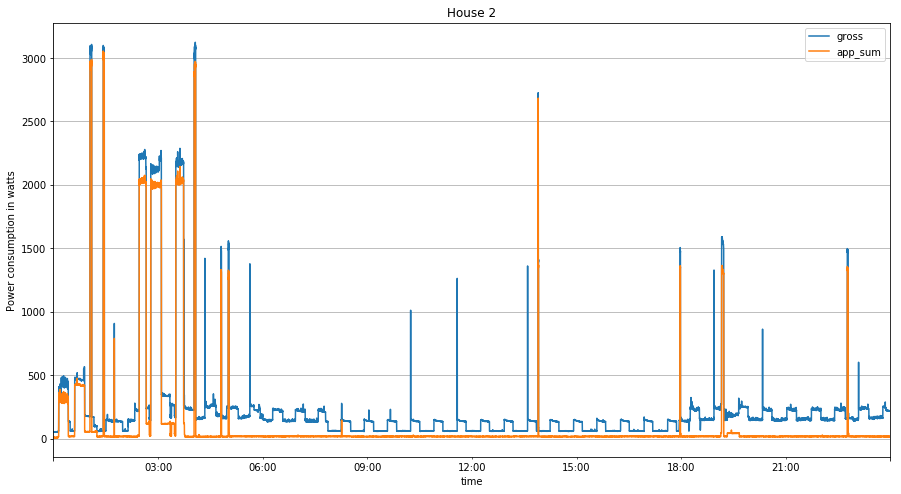

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

ax = sub_df[['gross', 'app_sum']].plot(ax=ax)
ax.grid(True)
ax.set_title('House {}'.format(selected_hid))
ax.set_ylabel('Power consumption in watts')

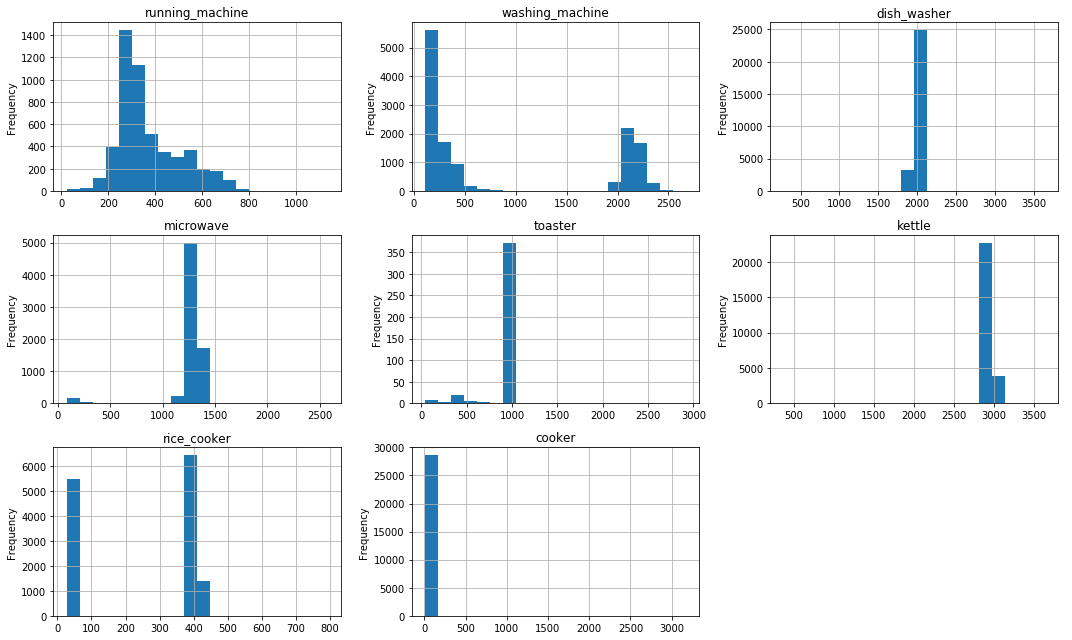

In [44]:
nrow = int(np.ceil(np.sqrt(len(appliance_cols))))
ncol = int(np.ceil(1.0 * len(appliance_cols) / nrow))

fig, axes = plt.subplots(nrow, ncol, figsize=(5*ncol, 3*nrow))
axes[-1, -1].axis('off')

for i, app in enumerate(appliance_cols):
  row_ix = i // 3
  col_ix = i % 3
  ax = axes[row_ix][col_ix]
  lb = energy_data[app].std()
  ub = energy_data[app].max() - lb
  energy_data[app + '_on'] = energy_data[app].apply(
      lambda x: 1 if x > lb else 0)
  energy_data[app][(energy_data[app] > lb) & 
                   (energy_data[app] < ub)].plot.hist(bins=20, ax=ax)
  ax.set_title(app)
  ax.grid(True)

plt.tight_layout()

In [46]:
energy_data.mean(axis=0)

modem                   8.993531
cooker                  0.179909
rice_cooker             2.912218
kettle                 45.684668
monitor                25.879006
laptop                 11.067621
router                  6.108015
server_hdd              2.018849
server                 13.867601
speakers                6.960742
playstation             0.955334
toaster                 0.598290
fridge                 54.477487
microwave               5.424965
laptop2                 3.729172
running_machine         2.793177
washing_machine        10.207630
dish_washer            33.497187
gross                 235.355403
app_sum               101.298045
running_machine_on      0.002954
washing_machine_on      0.007450
dish_washer_on          0.015989
microwave_on            0.004114
toaster_on              0.000238
kettle_on               0.015229
rice_cooker_on          0.007583
cooker_on               0.016298
dtype: float64

In [19]:
train_st = '2013-06-01 00:00:00'
train_et = '2013-07-31 23:59:59'
train_data = energy_data.loc[train_st:train_et]
print(train_data.shape)

valid_st = '2013-08-01 00:00:00'
valid_et = '2013-08-31 23:59:59'
valid_data = energy_data.loc[valid_st:valid_et]
print(valid_data.shape)

test_st = '2013-09-01 00:00:00'
test_et = '2013-09-30 23:59:59'
test_data = energy_data.loc[test_st:test_et]
print(test_data.shape)

(878400, 20)
(446400, 20)
(432000, 20)


In [22]:

train_file = os.path.join(raw_data_dir, 'house_{}/train.csv'.format(selected_hid))
valid_file = os.path.join(raw_data_dir, 'house_{}/valid.csv'.format(selected_hid))
test_file = os.path.join(raw_data_dir, 'house_{}/test.csv'.format(selected_hid))
print(train_file)
print(os.getcwd())

/content/sample_data/house_2/train.csv
/content


In [23]:
with open(train_file, 'w') as f:
  train_data.to_csv(f)
print('train_data saved.')

with open(valid_file, 'w') as f:
  valid_data.to_csv(f)
print('valid_data saved.')
  
with open(test_file, 'w') as f:
  test_data.to_csv(f)
print('test_data saved.')

train_data saved.
valid_data saved.
test_data saved.


## Splitted Data inspection

In [24]:
train_file = os.path.join(raw_data_dir, 'house_{}/train.csv'.format(selected_hid))
valid_file = os.path.join(raw_data_dir, 'house_{}/valid.csv'.format(selected_hid))
test_file = os.path.join(raw_data_dir, 'house_{}/test.csv'.format(selected_hid))

In [25]:
# @title Peek at the input file

with open(train_file, 'r') as f:
  train_data = pd.read_csv(f, index_col=0)

print(pd.Series(train_data.columns))
train_data.head()

0               modem
1              cooker
2         rice_cooker
3              kettle
4             monitor
5              laptop
6              router
7          server_hdd
8              server
9            speakers
10        playstation
11            toaster
12             fridge
13          microwave
14            laptop2
15    running_machine
16    washing_machine
17        dish_washer
18              gross
19            app_sum
dtype: object


,modem,cooker,rice_cooker,kettle,monitor,laptop,router,server_hdd,server,speakers,playstation,toaster,fridge,microwave,laptop2,running_machine,washing_machine,dish_washer,gross,app_sum
time,,,,,,,,,,,,,,,,,,,,
2013-06-01 00:00:01,9,0,1,1,60,47,6,1,13,10,0,0,10,0,0,1,3,0,162,6
2013-06-01 00:00:07,9,0,1,1,60,53,7,1,14,10,0,0,10,0,0,1,3,0,170,6
2013-06-01 00:00:13,9,0,1,1,60,50,7,1,14,10,0,0,10,0,0,1,3,1,168,7
2013-06-01 00:00:19,9,0,1,1,60,52,6,1,14,10,1,0,10,0,0,1,3,1,170,7
2013-06-01 00:00:25,9,0,1,1,60,45,7,1,14,10,1,0,10,0,0,1,3,1,164,7


In [27]:
appliance_cols = [x for x in train_data.columns if '_on' in x]
print(train_data[appliance_cols].mean())

Series([], dtype: float64)


In [28]:
with open(test_file, 'r') as f:
  test_data = pd.read_csv(f, index_col=0)

print(test_data.shape)
print(test_data[appliance_cols].mean())

(432000, 20)
Series([], dtype: float64)


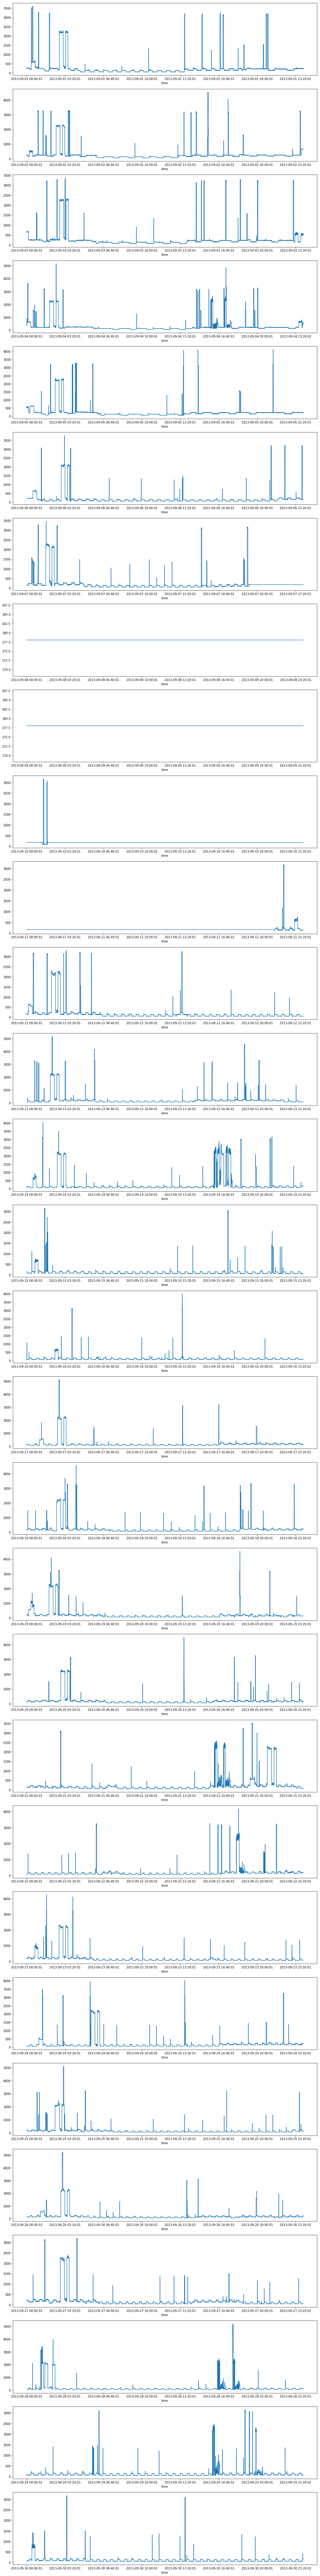

In [29]:
ss = ['2013-09-{0:02d} 00:00:00'.format(i+1) for i in range(30)]
ee = ['2013-09-{0:02d} 23:59:59'.format(i+1) for i in range(30)]


fig, axes = plt.subplots(30, 1, figsize=(15, 120))
for i, (s, e) in enumerate(zip(ss, ee)):
  test_data.loc[s:e].gross.plot(ax=axes[i])
  axes[i].set
plt.tight_layout()